# Graph Initialization

## Generate a random dense graph using NetworkX

In [19]:
import networkx as nx

NUMBER_OF_NODES = 100
NUMBER_OF_EDGES = 200
SEED = 13

G = nx.generators.dense_gnm_random_graph(NUMBER_OF_NODES, NUMBER_OF_EDGES, seed=SEED)


### (Optional) Generate a graph manually using NetworkX

In [11]:
G = nx.Graph()

G.add_nodes_from([1,5])
G.add_edges_from([(1,3),(1,2),(2,4),(2,5)])

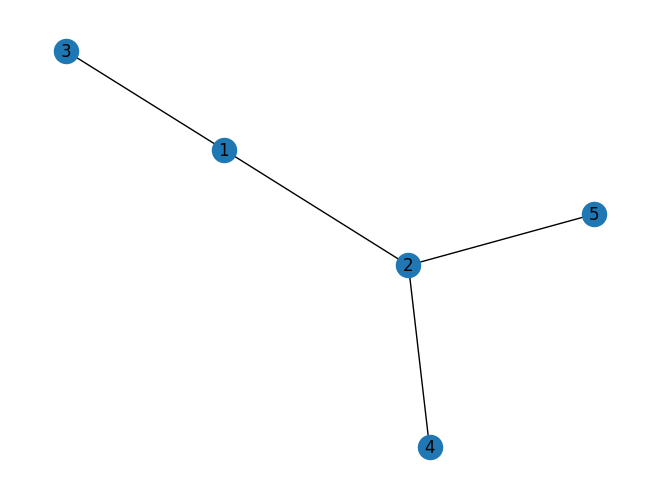

In [12]:
nx.draw(G,with_labels=True)

# Graph Reduction using linear programming

In [13]:
N_number_of_nodes_org = len(G.nodes)
M_number_of_edges_org = len(G.edges)

###### Question: When we use LP reduction, do we always end up with a reduced graph that consists of disjoint subgraphs?
## Answer: not always

components_before = [G.subgraph(c).copy() for c in nx.connected_components(G)]

## Remove self loops

In [14]:
import numpy as np

################################# remove self loops
self_loop_removal_cntr = 0
for pair in list(G.edges):
    if pair[0] == pair[1]:
        G.remove_edge(pair[0],pair[1])
        self_loop_removal_cntr = self_loop_removal_cntr+1
        print("self loop in node {} is removed".format([pair[0]]))
print("ALREADY REMOVED {} EDGES BECAUSE OF SELF LOOP".format(self_loop_removal_cntr))

ALREADY REMOVED 0 EDGES BECAUSE OF SELF LOOP


## Perform LP using CPlex

In [15]:
import cplex

#############################################################
################### LP ###################
#############################################################
########## INPUT: G
########## set of x_n = 1

problem = cplex.Cplex()

list_of_nodes = list(G.nodes)
list_of_pairs_of_edges = list(G.edges)

### dictionary of id's
node_id = {(n): 'node_id({0})'.format(n) for (n) in list_of_nodes}
problem.objective.set_sense(problem.objective.sense.maximize)
problem.variables.add(names=list(node_id.values()),lb=[0.0]*len(node_id))

## objective:
problem.objective.set_linear(list(zip(list(node_id.values()), [1.0] * len(node_id))))

## constraint: for all (u,v)\in E, node_id(u) + node_id(v) <= 1
""" Constraint (1) """
for (u,v) in list_of_pairs_of_edges:
    #if u != v:
    lin_expr_vars_1 = []
    lin_expr_vals_1 = []
    lin_expr_vars_2 = []
    lin_expr_vals_2 = []
    lin_expr_vars_1.append(node_id[(u)])
    lin_expr_vals_1.append(1.0)
    lin_expr_vars_2.append(node_id[(v)])
    lin_expr_vals_2.append(1.0)
    problem.linear_constraints.add(lin_expr=[
        cplex.SparsePair(lin_expr_vars_1 + lin_expr_vars_2, val=lin_expr_vals_2 + lin_expr_vals_2)],
        rhs=[1.0], senses=["L"],
        names=['(1)_'])


## write program for testing
#problem.write("LP_test.lp")
problem.solve()

if problem.solution.get_solution_type() == 0:
    print("CPLEX is outputting no solution exists")
if problem.solution.get_solution_type() != 0:

    node_id_star = problem.solution.get_values()
    ### removing nodes in (node_id_star == 1) along with their nieghbors
    nodes_to_be_removed = np.where(np.array(node_id_star)==1)

    if len(nodes_to_be_removed[0])==0:
        print("############# LP is solved , BUT without any nodes to be removed ##############")

    nodes_removed_from_LP_reduction=[]
    for node in nodes_to_be_removed[0]:
        # if node is still in graph
        if node in G.nodes:
            # find nieghbors
            nieghbor_list = list(G[int(node)])
            # remove node
            G.remove_node(node)
            nodes_removed_from_LP_reduction.append(node)
            print("LP removing ", node)
            for nie_node in nieghbor_list:
                G.remove_node(nie_node)
                nodes_removed_from_LP_reduction.append(nie_node)
                print("LP removing ", nie_node, "since its a nieghbor of", node)

    if len(G.nodes) == 0:
        print("THIS IS a CASE where a MIS is found with the LP with cardinality = ", np.count_nonzero(node_id_star))


    # re-label reduced graph from 0 to N
    G = nx.relabel.convert_node_labels_to_integers(G)

    ### number to be added to the final MIS of the reduced graph is:
    print("NUMBER of nodes in the MIS that we got from the LP", len(nodes_to_be_removed[0]))

#######################################################################################################################
#######################################################################################################################
#######################################################################################################################

N_number_of_nodes = len((G.nodes))
M_number_of_edges = len((G.edges))

M_number_of_edges_comp = (N_number_of_nodes*(N_number_of_nodes-1)/2) - M_number_of_edges

print("Before LP {} - After LP  {}".format([N_number_of_nodes_org, M_number_of_edges_org],[N_number_of_nodes, M_number_of_edges]))

components_after = [G.subgraph(c).copy() for c in nx.connected_components(G)]

print(f"number of dis-joint subgraphs of G = [Before LP: {len(components_before)}, After LP: {len(components_after)}]")

Version identifier: 22.1.1.0 | 2023-02-11 | 22d6266e5
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 4 rows and 5 columns.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.00 ticks)
LP removing  1
LP removing  3 since its a nieghbor of 1
LP removing  2 since its a nieghbor of 1
LP removing  4
NUMBER of nodes in the MIS that we got from the LP 3
Before LP [5, 4] - After LP  [1, 0]
number of dis-joint subgraphs of G = [Before LP: 1, After LP: 1]


# NN Generation

In [20]:
import time
import networkx as nx
import torch
import numpy as np

def datalessNN_graph_params(graph, seed=10, numpy_dtype=np.float32, torch_dtype=torch.float32):

    ## Normalize graph labels to 0 - {Number of nodes} (this will help with indexing our graph-related weights)
    G = nx.relabel.convert_node_labels_to_integers(graph)

    

    ## Set numpy seed. This is used for theta initialization
    np.random.seed(seed=seed)

    ## Graph order: number of nodes. Graph size: number of edges.
    graph_order = len((G.nodes))
    graph_size = len((G.edges))
    graph_complement_size = (graph_order*(graph_order-1))//2 - graph_size

    ##################################################################################################
    ##################################################################################################
    ################### MODIFY WEIGHTS of NN_p BASED ON GRAPH
    ##################################################################################################
    ##################################################################################################

    ##############################
    ## Theta value initilization
    ##############################
    list_of_node_degrees = [None]*graph_order
    for i in range(0, graph_order):
        list_of_node_degrees[i] = G.degree[i]
    
    max_node_degree_in_graph = np.max(list_of_node_degrees)

    theta_vector = np.zeros(graph_order, dtype=numpy_dtype)

    for i in range(0, graph_order):
        ## To prevent exact repititive probability: add some very small epsilon
        theta_vector[i] = (
            1 - (list_of_node_degrees[i] / max_node_degree_in_graph) + np.random.uniform(low=0.0, high=0.1)
        )

    ###############################################
    ## Second layer weight and bias initilization
    ###############################################

    #### This is the numpy array we need to update the weights of the second layer (N x (N+M+Mc))
    second_layer_weights = np.zeros(shape=(graph_order, graph_order + graph_size + graph_complement_size), dtype=numpy_dtype)

    #### Initilize the portion of the weight matrix reserved for the nodes of G
    for i in range(graph_order):
        second_layer_weights[i, i] = 1.0  # this stays the same


    #### Initilize the portion of the weight matrix reserved for the edges of G
    for idx, pair in enumerate(G.edges):
        second_layer_weights[pair[0], graph_order + idx] = 1.0
        second_layer_weights[pair[1], graph_order + idx] = 1.0

    #### Initilize the portion of the weight matrix reserved for the edges of G'
    G_complement = nx.complement(G)
    for idx, pair in enumerate(G_complement.edges):
        second_layer_weights[pair[0], graph_order + graph_size + idx] = 1.0
        second_layer_weights[pair[1], graph_order + graph_size + idx] = 1.0
    del G_complement


    #### This is the numpy array we need to update the biases of the second layer (N+M+Mc)
    second_layer_biases = np.zeros(shape=(graph_order + graph_size + graph_complement_size), dtype=numpy_dtype)

    ## Initilize the portion of the bias vector reserved for the nodes of G
    second_layer_biases[0:graph_order] = -0.5

    ## Initilize the portion of the bias vector reserved for the edges of G and G'
    second_layer_biases[
        graph_order : graph_order + graph_size + graph_complement_size
    ] = -1.0

    ##############################################
    ## Third layer weight initilization
    ##############################################

    #### This is the numpy array we need to update the weights of the third layer (N+M+Mc)
    third_layer_weights = np.zeros(shape=(graph_order + graph_size + graph_complement_size), dtype=numpy_dtype)


    #### add here from graph:
    third_layer_weights[0:graph_order] = -1.0
    third_layer_weights[graph_order : graph_order + graph_size] = graph_order
    third_layer_weights[graph_order + graph_size :] = -1.0

    T_1 = torch.clamp(torch.tensor(theta_vector, dtype=torch_dtype), 0.1, 0.9)
    W_2 = torch.tensor(second_layer_weights, dtype=torch_dtype)
    B_2 = torch.tensor(second_layer_biases, dtype=torch_dtype)
    W_3 = torch.tensor(third_layer_weights, dtype=torch_dtype)

    return {"theta_tensor": T_1, "layer_2_weights": W_2, "layer_2_biases": B_2, "layer_3_weights": W_3}

In [21]:
import torch
import numpy as np

class ElementwiseMultiply(torch.nn.Module):
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: torch.Tensor

    def __init__(self, in_features, out_features, lower_bound=0, upper_bound=1):
        super().__init__()
        self.in_features, self.out_features = in_features, out_features
        weights = torch.Tensor(in_features, out_features)
        self.weight = torch.nn.Parameter(weights)
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound

    def forward(self, x):        
        # Perform element-wise multiplication
        result = torch.mul(torch.Tensor(x), self.weight.t())
        
        # Bound the output between the specified lower and upper bounds
        result = torch.clamp(result, self.lower_bound, self.upper_bound)
        return result
    
class ZeroOneClamp(object):
    def __init__(self):
        pass

    def __call__(self, module):
        w = module.weight.data
        module.weight.data = torch.clamp(w, 0, 1)


def datalessNN(theta_tensor, layer2_weights, layer2_biases, layer3_weights, numpy_dype=np.float32, torch_dtype=torch.float32):

    graph_order = len(theta_tensor)
    graph_nodes_and_all_possible_edges = len(layer2_biases)

    ##################################################################3################################################
    ################################3 initialize NN ##################################################################3
    ##################################################################3################################################

    NN = torch.nn.Sequential()

    ###############################
    ## Theta Layer initialization
    ###############################
    theta_layer = ElementwiseMultiply(in_features=graph_order, out_features=graph_order)

    # Temporarily disable gradient calc to set initial weights
    with torch.no_grad():
        theta_layer.weight.data = theta_tensor

    NN.append(theta_layer)

    ################################
    ## Second Layer initialization
    ################################
    layer2 = torch.nn.Linear(
        in_features=graph_order,
        out_features=graph_nodes_and_all_possible_edges,
        bias=True,
        dtype=torch_dtype
    )
    # add ReLu activation layer to layer 2
    layer2_activation = torch.nn.ReLU()

    # make layer non-trainable
    layer2.requires_grad_(False)

    # Initialize weights and biases
    layer2.weight.data = np.transpose(layer2_weights)
    layer2.bias.data = layer2_biases

    NN.append(layer2)
    NN.append(layer2_activation)

    ###############################
    ## Third Layer initialization
    ###############################
    layer3 = torch.nn.Linear(
        in_features=graph_nodes_and_all_possible_edges, out_features=1, bias=False
    )

    # make layer non-trainable
    layer3.requires_grad_(False)

    # Initialize weights
    layer3.weight.data = layer3_weights
    
    NN.append(layer3)

    return NN

training_step =  0 value =  Parameter containing:
tensor([0.8853, 0.7193, 0.6897, 0.5194, 0.5853, 0.6488, 0.3734, 0.6115, 0.5524,
        0.8170, 0.2404, 0.8126, 0.6268, 0.8900, 0.5258, 0.8694, 0.6985, 0.8374,
        0.8091, 0.8796, 0.5897, 0.5497, 0.6637, 0.6938, 0.7615, 0.8516, 0.8700,
        0.7686, 0.6005, 0.8900, 0.6160, 0.6785, 0.7172, 0.8401, 0.7263, 0.5655,
        0.7287, 0.8900, 0.4492, 0.4163, 0.4084, 0.6174, 0.3735, 0.7120, 0.3888,
        0.5200, 0.8900, 0.8057, 0.5680, 0.7338, 0.7565, 0.9100, 0.8900, 0.7324,
        0.7557, 0.7208, 0.8160, 0.9100, 0.8900, 0.4697, 0.8900, 0.7166, 0.4980,
        0.5036, 0.6303, 0.4803, 0.1798, 0.8387, 0.7503, 0.7947, 0.2667, 0.1000,
        0.7488, 0.7809, 0.4792, 0.7216, 0.7144, 0.8845, 0.7142, 0.8499, 0.5960,
        0.7686, 0.4134, 0.6526, 0.6565, 0.8900, 0.6567, 0.6506, 0.5912, 0.5920,
        0.4011, 0.8375, 0.7237, 0.7242, 0.5694, 0.7668, 0.5423, 0.6704, 0.7491,
        0.5874], requires_grad=True)  ; desired value set for optimizt

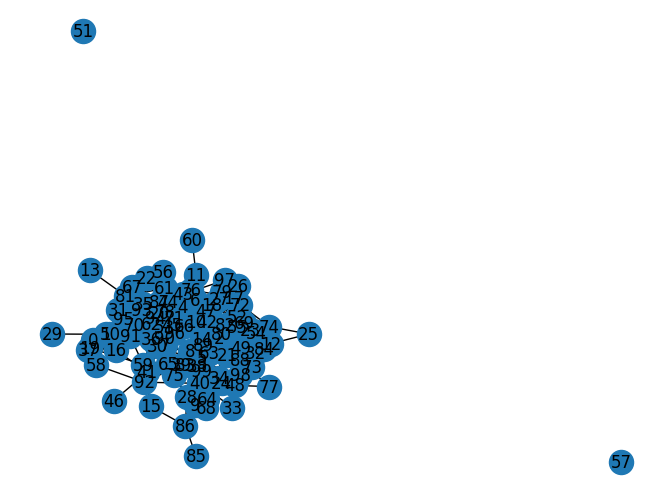

In [22]:
## generate graph weights
NN_graph_params = datalessNN_graph_params(G)

graph_order = len(G.nodes)

NN = datalessNN(
    NN_graph_params["theta_tensor"],
    NN_graph_params["layer_2_weights"],
    NN_graph_params["layer_2_biases"],
    NN_graph_params["layer_3_weights"])

################# optimization
# good and fast results on most is found at initial_learning_rate = 0.001
initial_learning_rate = 0.01
optimizer = torch.optim.Adam(NN.parameters(), lr=initial_learning_rate)
loss_fn = torch.nn.MSELoss()

theta_constraint = ZeroOneClamp()

##################################################################################################
##################################################################################################
##################################################################################################

batch_size_gen = 1
batch_size_2 = batch_size_gen

################################################################
##### X_train is the same for both gen and combined models #####
################################################################

X_train = np.ones(len(NN_graph_params["theta_tensor"]))

############################################################
### Y_train_combined is the v_d (desired value)
################################################################

P_desired = np.zeros(1)
P_desired[0] = -graph_order**2 / 2

Y_train_combined = np.zeros(shape=(batch_size_2, 1, 1))

Y_val_combined = P_desired.reshape(1, 1)
for i in range(batch_size_2):
    Y_train_combined[i, :, :] = Y_val_combined

Y_train_combined = Y_train_combined.reshape(batch_size_2, 1)

Y_desired = torch.Tensor(Y_val_combined)
Y_val_combined = Y_val_combined.reshape(1, 1, 1)
Y_val_combined = Y_val_combined.reshape(1, 1)
# Y_val_combined = Y_val_combined.reshape(3)

################################################################
### train
################################################################

training_steps = 2000

start = time.time()
for i in range(training_steps):
    predicted_y = NN(X_train)

    loss = loss_fn(predicted_y, Y_desired)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ## normalize theta values between 0 and 1
    NN[0].apply(theta_constraint)

    X_star = NN[0].weight

    if any(X_star > 1.0) or any(X_star < 0.0):
        print(
            "exit AT training step = ",
            i,
            "; THERE IS A A VALUE IN THE WEIGHTS OUTSIDE [0,1]",
            X_star
        )
        break

    # check MAXIMAL-IS multiple thresholds !!!
    # MAXIMAL_IS_tester = [
    #     MAXIMAL_IS_checker(X_star, G, 0.3),
    #     MAXIMAL_IS_checker(X_star, G, 0.4),
    #     MAXIMAL_IS_checker(X_star, G, 0.5),
    #     MAXIMAL_IS_checker(X_star, G, 0.6),
    #     MAXIMAL_IS_checker(X_star, G, 0.7),
    # ]

    # if MAXIMAL_IS_checker(X_star, G, 0.5) == 1:
    #     X_star_thresholded_IS = np.zeros(shape=(n_inputss))
    #     for ii in range(n_inputss):
    #         if X_star[ii] > 0.5:
    #             X_star_thresholded_IS[ii] = 1
    #     length_IS = np.count_nonzero(X_star_thresholded_IS)
    #     # length_IS_w_Imp = np.count_nonzero(
    #     #     X_star_thresholded_IS
    #     # ) + solution_improve_alg(
    #     #     X_star_thresholded_IS, G, np.count_nonzero(X_star_thresholded_IS)
    #     # )
    #     print(
    #         "IS is found at step ",
    #         [i],
    #         "with size = ",
    #         length_IS,
    #         # "total with improvement = ",
    #         # length_IS_w_Imp,
    #     )

    # ## exit if we already have a Maximal-IS
    # if any(np.array(MAXIMAL_IS_tester) == 1):
    #     winning_threshold_temp = np.argmax(np.array(MAXIMAL_IS_tester))
    #     winning_threshold = [0.3, 0.4, 0.5, 0.6, 0.7][winning_threshold_temp]
    #     end = time.time()
    #     X_star_thresholded = np.zeros(shape=(n_inputss))
    #     # X_MIN_VALUE_TEST   = np.zeros(shape=(n_inputss))
    #     for ii in range(n_inputss):
    #         if X_star[ii] > winning_threshold:
    #             X_star_thresholded[ii] = 1
    #     length = np.count_nonzero(X_star_thresholded) #+ solution_improve_alg(
    #     #     X_star_thresholded, G, np.count_nonzero(X_star_thresholded)
    #     # )

    #     print(
    #         "MAXIMAL-IS IS FOUND AT training step = ",
    #         i,
    #         "; Cardinality Ours = ",
    #         [length],
    #     )
    #     # if length >= some_value_if_known:
    #     Solution_pool_length.append(length)
    #     break

    print(
        "training_step = ",
        i,
        "value = ",
        X_star,
        " ; desired value set for optimiztion = ",
        [P_desired],
    )


nx.draw(G,with_labels=True)
print("break")